In [1]:
import numpy as np
import xroms
from glob import glob
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import sys
import xrft
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle

from dask.diagnostics import ProgressBar
import dask
from dask.distributed import Client, LocalCluster

import scipy.integrate as integ
warnings.filterwarnings("ignore")
import seawater as sw


In [2]:

def xr_pden(s,t,p,xr_coords,xr_dims,pr=0):
    pden=sw.pden(s=s,t=t,p=p,pr=pr)
    return xr.DataArray(pden,coords=xr_coords,dims=xr_dims)

In [3]:
# chunks={'time_counter':10, 'x_rho':50, 'y_rho':190,'s_rho':80,'s_w':80}
chunks={'time_counter':1,'x_rho':1000,"x_u":1000,"x_v":1000,
                        'y_rho':1520,"y_u":1520,"y_v":1520,'s_rho':80,'s_w':80}

M='01'
path='/data/pacific/lrenault/SASI/CROCO/'

varf=xr.open_mfdataset(path + 'FULL/SASI*2012-{0}*.nc'.format(M),data_vars='minimal',chunks=chunks)
vart=xr.open_mfdataset(path + 'SMTH/SASI*2012-{0}*.nc'.format(M),data_vars='minimal',chunks=chunks)

# varf=xr.open_mfdataset(path + 'FULL/SASI*2012*.nc',data_vars='minimal',chunks=chunks)
# vart=xr.open_mfdataset(path + 'SMTH/SASI*2012*.nc',data_vars='minimal',chunks=chunks)

In [4]:
varx = varf.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v","x_w":"xi_w",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
df,gf=xroms.roms_dataset(varx,Vtransform=varx.Vtransform.data)

vary = vart.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
dt,gt=xroms.roms_dataset(vary,Vtransform=vary.Vtransform.data)

In [5]:
timer_h=pd.DatetimeIndex(dt.ocean_time)
timer_d=pd.DatetimeIndex(dt.ocean_time.groupby("ocean_time.dayofyear").mean())

In [6]:
ix=0

In [7]:
temp_full=df.temp[ix,:,120:-120,120:800]
temp_smth=dt.temp[ix,:,120:-120,120:800]

salt_full=df.salt[ix,:,120:-120,120:800]
salt_smth=dt.salt[ix,:,120:-120,120:800]

In [8]:
%%time
# rho_full=df.rho[ix,:,120:-120,120:800]+df.rho0
# rho_smth=dt.rho[ix,:,120:-120,120:800]+dt.rho0

# rho_full=xr_pden(s=salt_full.compute()[::-1,:,:],t=temp_full.compute()[::-1,:,:],p=-temp_full.z_rho0.compute()[::-1,:,:],
#                  xr_coords=temp_full.compute()[::-1,:,:].coords,xr_dims=temp_full.compute()[::-1,:,:].dims,pr=0)
# rho_smth=xr_pden(s=salt_smth.compute()[::-1,:,:],t=temp_smth.compute()[::-1,:,:],p=-temp_smth.z_rho0.compute()[::-1,:,:],
#                  xr_coords=temp_smth.compute()[::-1,:,:].coords,xr_dims=temp_smth.compute()[::-1,:,:].dims,pr=0)

rho_full=temp_full.copy(data=sw.pden(s=salt_full,t=temp_full,p=-temp_full.z_rho,pr=0))
rho_smth=temp_full.copy(data=sw.pden(s=salt_smth,t=temp_smth,p=-temp_smth.z_rho,pr=0))

CPU times: user 15.1 s, sys: 7.21 s, total: 22.3 s
Wall time: 36.2 s


In [11]:
zSurf=temp_full.z_rho0.compute().max()
zBott=temp_full.z_rho0.compute().min()

In [30]:
z_surf_interp=-2
dz=10
z_interp=np.linspace(z_surf_interp,zBott, np.int(np.abs(zBott/dz)))
print('dz={0:.1f}'.format(np.diff(z_interp).mean()) +  '   n_z={0:.0f}'.format(np.int(np.abs(zBott/dz))))

dz=-10.0   n_z=507


In [31]:
%%time
dec=1
Zstar_full=xr.DataArray(coords=(
                                z_interp,
                                rho_full.eta_rho.data,
                                rho_full.xi_rho.data),
                      dims=['z_rho','eta_rho','xi_rho'])


CPU times: user 145 ms, sys: 253 ms, total: 398 ms
Wall time: 398 ms


In [32]:
def data_filler(data_sort,nan_sort):
    dummy_data=[]
    d_i=0
    for xd in range(len(data_sort)):
        if nan_sort[xd]==False:
            dummy_data.append(data_sort[d_i])
            d_i+=1
        elif nan_sort[xd]==True:
            dummy_data.append(np.nan)
        # print('{0}'.format(xd) + ' / {0}'.format(len(data_sort)),end='\r',flush=True)
    return np.array(dummy_data)

In [33]:
%%time
rho_full_interp=rho_full[:,:,:].xroms.isoslice(z_interp).compute() #interpolating p dens to the maximum depth possible

rho_full_stacked=np.ravel(rho_full_interp) #flatten rho grid
index_sorted_full=np.argsort(rho_full_stacked) #sort rho vector
rho_sorted_full=np.argsort(rho_full_stacked) #sort rho vector

nan_stacked=np.isnan(rho_full_stacked) #keep track of the nan locations



CPU times: user 1min 37s, sys: 1.64 s, total: 1min 39s
Wall time: 1min 34s


In [34]:
%%time
rho_sorted_full=np.sort(rho_full_stacked) #sort rho vector

CPU times: user 33.8 s, sys: 247 ms, total: 34.1 s
Wall time: 34.1 s


In [35]:
%%time
rho_full_stacked_nansmart=data_filler(data_sort=rho_sorted_full,nan_sort=nan_stacked)

CPU times: user 9min 32s, sys: 5.81 s, total: 9min 37s
Wall time: 9min 39s


In [36]:
%%time
rho_star_nansmart=rho_full_interp.copy(data=rho_full_stacked_nansmart[index_sorted_full].reshape(rho_full_interp.shape))
rho_star=rho_full_interp.copy(data=rho_full_stacked[index_sorted_full].reshape(rho_full_interp.shape))

rho_star_m=rho_full_interp.copy(data=np.tile(rho_star.mean(['xi_rho','eta_rho']),
                                             (rho_full_interp.shape[2],rho_full_interp.shape[1],1)).T)


CPU times: user 5.44 s, sys: 1.04 s, total: 6.48 s
Wall time: 6.49 s


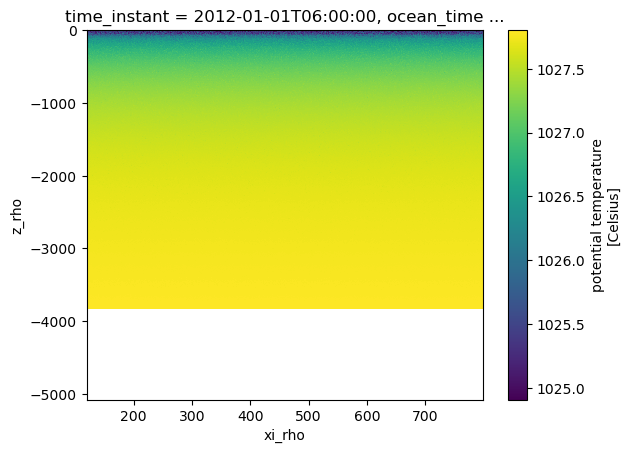

In [48]:
rho_star_nansmart[:,600,:].plot()

(1026.0, 1028.0)

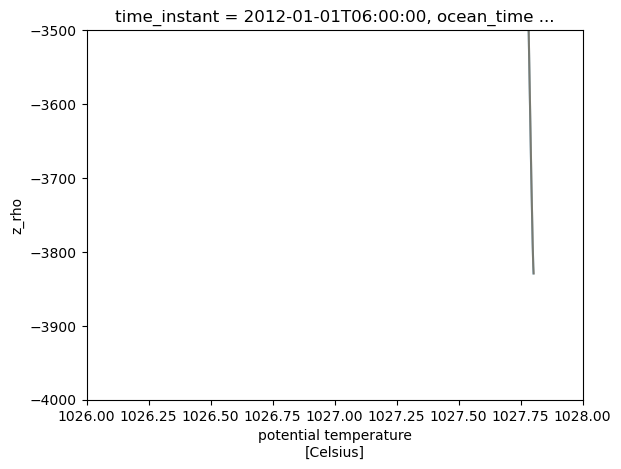

In [46]:
rho_star_nansmart.mean(['eta_rho','xi_rho']).plot(y='z_rho',alpha=1)
rho_star.mean(['eta_rho','xi_rho']).plot(y='z_rho',alpha=0.4)
plt.ylim(-4000,-3500)
plt.xlim(1026,1028)

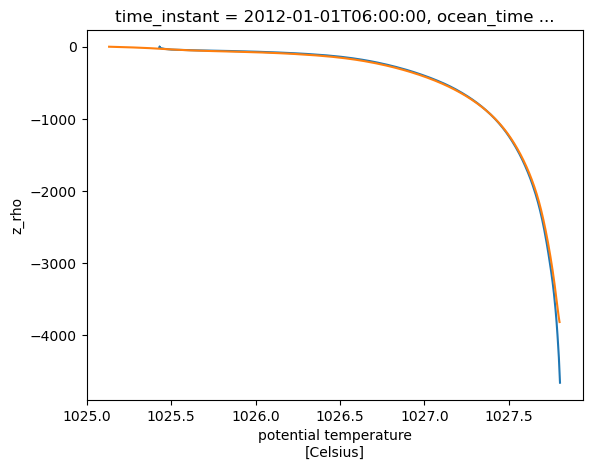

In [29]:
rho_full_interp[:,600,:].mean(axis=1).plot(y='z_rho')
rho_star[:,600,:].mean(axis=1).plot(y='z_rho')
# rho_full_interp[:,600,:].plot()
# plt.figure()
# rho_star[:,600,:].plot()

### Method of argsort

In [ ]:

# Rho_full_interp[day_x,:,:,:]=rho_full_interp

"numpy method (working but janky)"
rho_full_stacked=np.ravel(rho_full_interp)
index_sorted_full=np.argsort(rho_full_stacked)

rho_star=rho_full_interp.copy(data=rho_full_stacked[index_sorted_full].reshape(rho_full_interp.shape))
rho_star_m=rho_full_interp.copy(data=np.tile(rho_star.mean(['xi_rho','eta_rho']),
                                             (rho_full_interp.shape[2],rho_full_interp.shape[1],1)).T)


In [197]:
%%time

rho_full_interp=rho_full[:,:,:].xroms.isoslice(z_interp).compute()
# Rho_full_interp[day_x,:,:,:]=rho_full_interp

"numpy method (working but janky)"
rho_full_stacked=np.ravel(rho_full_interp)
index_sorted_full=np.argsort(rho_full_stacked)

rho_star=rho_full_interp.copy(data=rho_full_stacked[index_sorted_full].reshape(rho_full_interp.shape))
rho_star_m=rho_full_interp.copy(data=np.tile(rho_star.mean(['xi_rho','eta_rho']),
                                             (rho_full_interp.shape[2],rho_full_interp.shape[1],1)).T)

for zi in range(z_interp.shape[0]):
    Zstar_full[zi,:,:]=z_interp[(np.abs(rho_full_interp[zi,:,:]-rho_star_m)).argmin('z_rho')]

ValueError: All-NaN slice encountered

In [31]:
# z_matrix=np.zeros([z_interp.shape[0],rho_full.shape[2],rho_full.shape[3]])
z_matrix=np.zeros([z_interp.shape[0],rho_full.shape[1],rho_full.shape[2]])
# z_matrix[:,:,:]=-z_interp[:,None,None]

In [32]:
dec=1
Zstar_full=xr.DataArray(coords=(df.ocean_time[::dec],
                                z_interp,
                                rho_full.eta_rho.data,
                                rho_full.xi_rho.data),
                      dims=['ocean_time','z_rho','eta_rho','xi_rho'])

Rho_full_interp=xr.DataArray(coords=(df.ocean_time[::dec],
                                z_interp,
                                rho_full.eta_rho.data,
                                rho_full.xi_rho.data),
                      dims=['ocean_time','z_rho','eta_rho','xi_rho'])

In [ ]:
%%time
"NEW METHOD"


for day_x in range(rho_full.ocean_time.shape[0]):


    rho_full_interp=rho_full[day_x,:,:,:].xroms.isoslice(z_interp).compute()
    # rho_full_interp['z_rho']=z_interp
    Rho_full_interp[day_x,:,:,:]=rho_full_interp

    "numpy method (working but janky)"
    rho_full_stacked=np.ravel(rho_full_interp)
    index_sorted_full=np.argsort(rho_full_stacked)

    rho_star=rho_full_interp.copy(data=rho_full_stacked[index_sorted_full].reshape(rho_full_interp.shape))
    rho_star_m=rho_full_interp.copy(data=np.tile(rho_star.mean(['xi_rho','eta_rho']),
                                                 (rho_full_interp.shape[2],rho_full_interp.shape[1],1)).T)

    for zi in range(z_interp.shape[0]):
        Zstar_full[day_x,zi,:,:]=z_interp[(np.abs(rho_full_interp[zi,:,:]-rho_star_m)).argmin('z_rho')]

In [ ]:
%%time
Zstar_full.to_netcdf('/data/pacific/iufarias/z_star/z_star_full_newmethod_M{0}.nc'.format(M))
del Zstar_full

In [ ]:
%%time
Rho_full_interp.to_netcdf('/data/pacific/iufarias/z_star/rho_full_M{0}.nc'.format(M))
del Rho_full_interp

In [ ]:
Zstar_smth=xr.DataArray(coords=(dt.ocean_time[::dec],
                                z_interp,
                                rho_smth.eta_rho,
                                rho_smth.xi_rho),
                      dims=['ocean_time','z_rho','eta_rho','xi_rho'])

Rho_smth_interp=xr.DataArray(coords=(dt.ocean_time[::dec],
                                z_interp,
                                rho_smth.eta_rho,
                                rho_smth.xi_rho),
                      dims=['ocean_time','z_rho','eta_rho','xi_rho'])

In [ ]:
%%time
"NEW METHOD"
for day_x in range(rho_smth.ocean_time.shape[0]):


    rho_smth_interp=rho_smth[day_x,:,:,:].xroms.isoslice(z_interp).compute()
    # rho_smth_interp['z_rho']=z_interp_rev
    Rho_smth_interp[day_x,:,:,:]=rho_smth_interp

    "numpy working hod (working but janky)"
    rho_smth_stacked=np.ravel(rho_smth_interp)
    index_sorted_smth=np.argsort(rho_smth_stacked)

    rho_star=rho_smth_interp.copy(data=rho_smth_stacked[index_sorted_smth].reshape(rho_smth_interp.shape))
    rho_star_m=rho_smth_interp.copy(data=np.tile(rho_star.mean(['xi_rho','eta_rho']),
                                                 (rho_smth_interp.shape[2],rho_smth_interp.shape[1],1)).T)

    for zi in range(z_interp.shape[0]):
        Zstar_smth[day_x,zi,:,:]=z_interp[(np.abs(rho_smth_interp[zi,:,:]-rho_star_m)).argmin('z_rho')]

In [ ]:
%%time
Zstar_smth.to_netcdf('/data/pacific/iufarias/z_star/z_star_smth_newmethod_M{0}.nc'.format(M))
del Zstar_smth

In [ ]:
%%time
Rho_smth_interp.to_netcdf('/data/pacific/iufarias/z_star/rho_smth_M{0}.nc'.format(M))
del Rho_smth_interp